<a href="https://colab.research.google.com/github/adrianmarino/neural-network-from-scratch/blob/master/Neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Neural Network From Scratch

In [0]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

## 1. Utilities used to plot and inspect (DO NOT READ THIS SECTION INITIALLY, GO TO SECTION 2 :) )

In this session only exist utils and helper classes for inspect network structure.**This code is not important to interstand  hwo works a Neural network.** 

**Note**: **draw_neural_net** funcion was taken from: [craffel/draw_neural_net.py](https://gist.github.com/craffel/2d727968c3aaebd10359) github repository.

In [0]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            position = (n*h_spacing + left, layer_top - m*v_spacing)
            circle = plt.Circle(
                (n*h_spacing + left, layer_top - m*v_spacing), 
                v_spacing/4.,
                color= 'w',
                ec='k',
                zorder=4
            )
            ax.add_artist(circle)
            delta = (0.0003, 0.005)
            ax.annotate(
                'N' if n else 'I', 
                xy=(position[0] - delta[0], position[1] - delta[1]), 
                fontsize=10, 
                ha="center",
                zorder=5
            )
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

In [0]:
class NetworkPlotter:
    def __init__(self, network): self.network = network

    def __layers_size(self):
        layers = []
        for index,layer in enumerate(self.network.layers):
            layers.append(layer.inputs)
            if index == len(self.network.layers) - 1:
               layers.append(layer.neurons)
        return layers

    def __topology(self):
        return pd.DataFrame(
             [(l.name(), l.inputs,l.neurons, l.act_fn.name()) for l in self.network.layers],
            columns=['Layer', 'Inputs', 'Neurons', 'Activation']
        )

    def plot(self):
        fig = plt.figure(figsize=(14, 14))
        ax = fig.gca()
        ax.axis('off')
        draw_neural_net(ax, .1, .9, .1, .9, self.__layers_size())
        fig.savefig('nn.png')
        return self.__topology()


In [0]:
class DatasetPlotter:
    @staticmethod
    def plot(X, Y):
        plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c='skyblue')
        plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c='salmon')
        plt.axis('equal')
        plt.grid()
        plt.show()

In [0]:
class LossesPlotter:
    @staticmethod
    def plot(summary):
        plt.plot(summary.epochs, summary.train_losses, label='Train Loss', c='b')
        plt.plot(summary.epochs, summary.val_losses, label='Validation Loss',c='g')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.show()

In [0]:
class FunctionPlotter:
    def __init__(self, function): self.function = function

    def plot(self, x_values):
        plt.title(f'{self.function.name()} Function')
        plt.grid()
        plt.plot(x_values, [self.function.compute(x) for x in x_values])
        plt.show()

In [0]:
def normal_rand_tensor(*dimensions):
    """Allow create a tensor with specified dimensions 
    and random values bethween -1 and 1.
    
    Examples: 
        - normal_rand_tensor(2): Create a two elements array. 
        - normal_rand_tensor(2, 2): Create (2, 2) matrix.
        - normal_rand_tensor(2, 2, 2): Create (2, 2, 3) tensor.
        - etc...
    """
    return np.random.rand(*dimensions) * 2 - 1

In [0]:
class TrainSummary:
    def __init__(self):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.rows = []

    def add(self, epoch, train_loss, val_loss):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.rows.append((epoch, train_loss, val_loss))

    def show(self):
        return pd.DataFrame(self.rows, columns=['Epoch', 'Train Loss', 'Validation Loss'])


## 2. Create dataset

In [0]:
class CirclesDataset:
    def __init__(self, samples_count, factor, noise, shuffle=True):
        self.X, Y = make_circles(
            n_samples=samples_count, 
            factor=factor,
            noise=noise
        )
        # Change self.labels shape from (labels_count, ) to (labels_count, 1)..
        self.Y = np.reshape(Y, (Y.shape[0], 1))

    def train_test(self, test_size, shuffle=True):
        return train_test_split(self.X, self.Y, test_size=test_size, shuffle=shuffle)

    def plot(self): DatasetPlotter.plot(self.X, self.Y)

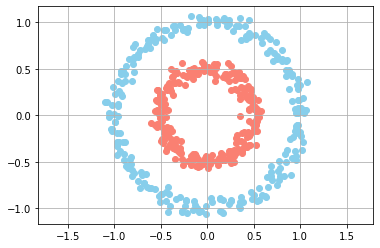

In [10]:
dataset = CirclesDataset(
    samples_count=500, 
    factor=0.5, 
    noise=0.05, 
    shuffle=True
)
dataset.plot()

## 3. Activation functions

In [0]:
from abc import ABCMeta, abstractmethod

# Abstract Class
class Function(metaclass=ABCMeta):
    @abstractmethod
    def compute(self, x): pass

    def derivate(self): return None
    
    def name(self): return self.__class__.__name__
    
    def plot(self, x_values): FunctionPlotter(self).plot(x_values)

In [0]:
class SigmoideFunction(Function):
    def compute(self, x): return 1 / (1 + np.e ** (-x))
    def derivate(self): return SigmoideDerivateFunction()

class SigmoideDerivateFunction(Function):
    def compute(self, x): return x * (1 -x)

In [0]:
class RELUFunction(Function):
    def compute(self, x): return np.maximum(0, x)
    def derivate(self): return RELUDerivateFunction()

class RELUDerivateFunction(Function):
    def compute(self, x): return 1 if x == 1 else 0

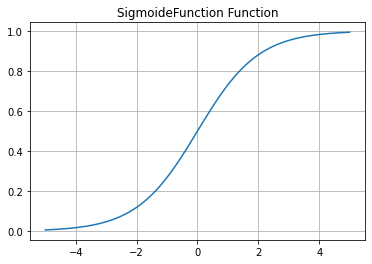

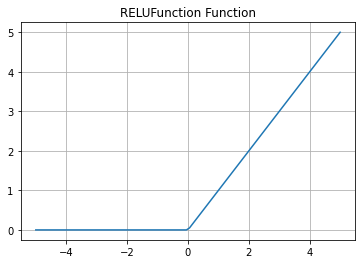

In [14]:
SigmoideFunction().plot(x_values=np.linspace(-5, 5, 100))
RELUFunction().plot(x_values=np.linspace(-5, 5, 100))

## 4. Neural network Layers

In [0]:
class LayerOutput:
    def __init__(self, weighted_sum, activation):
       self.weighted_sum = weighted_sum
       self.activation = activation

In [0]:
class DenseLayer:
    def __init__(self, inputs, neurons, act_fn):
        self.inputs = inputs
        self.neurons = neurons
        self.act_fn = act_fn
        self.biases = normal_rand_tensor(1, neurons)
        self.W = normal_rand_tensor(inputs, neurons)

    def name(self): return 'Dense'

    def compute(self, inputs):
        weighted_sum = inputs @ self.W + self.biases
        activation = self.act_fn.compute(weighted_sum)
        return LayerOutput(weighted_sum, activation) 

## 5. Neural network builder

In [0]:
class NetworkBuilder:
    def __init__(self): self.__layers = []
    
    def build(self): return Network(self.__layers)

    def resolve_inputs(self, default_inputs): 
        return self.__layers[-1].neurons if len(self.__layers) > 0 else default_inputs

    def dense(self, activation, neurons, inputs=-1):
        inputs = self.resolve_inputs(inputs)
        layer = DenseLayer(inputs, neurons, activation)
        self.__layers.append(layer)
        return self

    def sigm_dense(self, neurons, inputs=-1): 
        self.dense(SigmoideFunction(), neurons, inputs)
        return self

    def relu_dense(self, neurons, inputs=-1): 
        self.dense(RELUFunction(), neurons, inputs)
        return self

## 6. Neural network callbacks

In [0]:
import time

class TrainCallbackContext:
    def __init__(self, network, train_set, validation_set, loss_fn, update_interval):
        self.summary = TrainSummary()
        self.loss_fn = loss_fn
        self.network = network
        self.train_set = train_set
        self.validation_set = validation_set
        self.update_interval = update_interval

    def update(self, epoch, y_predicted):
        if epoch % self.update_interval == 0: 
            clear_output(wait=True)
            time.sleep(0.5)
        self.epoch = epoch
        self.y_predicted = y_predicted
        
# Abstract Class
class TrainCallback(metaclass=ABCMeta):
    @abstractmethod
    def perform(self, context):
        pass
    def result(self):
        return None

In [0]:
class TrainSummaryCallback(TrainCallback):
    def perform(self, ctx):
        train_loss = ctx.loss_fn.compute(ctx.y_predicted, ctx.train_set[1])

        val_y_pred = ctx.network.predict(ctx.validation_set[0])
        val_loss = ctx.loss_fn.compute(val_y_pred, ctx.validation_set[1])
        val_loss = np.mean(val_loss)

        ctx.summary.add(ctx.epoch, train_loss, val_loss)

In [0]:
class PlotLossesCallback(TrainCallback):
    def perform(self, ctx):
        if ctx.epoch % ctx.update_interval == 0:
            LossesPlotter.plot(ctx.summary)

In [0]:
class PlotLerningCallback(TrainCallback):
    def perform(self, ctx):
        if ctx.epoch % ctx.update_interval == 0:
            res = 50
            _x0 = np.linspace(-1.5, 1.5, res)
            _x1 = np.linspace(-1.5, 1.5, res)
            _Y = np.zeros((res, res))

            for i0, x0 in enumerate(_x0):
                for i1, x1 in enumerate(_x1):
                    y_predicted = ctx.network.predict(np.array([[x0, x1]]))
                    _Y[i0, i1] = y_predicted[0][0]

            plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
            plt.axis('equal')

            DatasetPlotter.plot(ctx.validation_set[0], ctx.validation_set[1])

## 7. Neural Network

In [0]:
class Network:
    def __init__(self, layers):
        self.layers = layers

    @staticmethod
    def builder(): return NetworkBuilder()
    
    def plot(self): return NetworkPlotter(self).plot() 

    def __forward_pass(self, X):
        outputs = [LayerOutput(None, X)]
        for layer in self.layers:
            outputs.append(layer.compute(outputs[-1].activation))   
        return outputs

    def predict(self, X):
        outputs = self.__forward_pass(X)
        return outputs[-1].activation

    def __backward_propagation(self, loss_fn, outputs, Y):
        errors = [] # Or deltas
        for layer_index in reversed(range(0, len(self.layers))):
            layer = self.layers[layer_index]
            act_value = outputs[layer_index+1].activation

            if not errors: # Is last layer?
                first_term = loss_fn.derivate().compute(act_value, Y)
            else:
                previous_layer = self.layers[layer_index + 1]
                previous_error = errors[0]
                first_term = previous_error @ previous_layer.W.T

            second_term = layer.act_fn.derivate().compute(act_value)
            errors.insert(0, first_term * second_term)
        return errors 
    
    def __gradient_desent_optimization(self, outputs, errors, lr):
        for layer_index in reversed(range(0, len(self.layers))):
            layer = self.layers[layer_index]    
            layer_error = errors[layer_index]
            layer_output = outputs[layer_index]

            mean_layer_error = np.mean(layer_error, axis=0, keepdims=True)            
            layer.biases = layer.biases - (mean_layer_error * lr)

            delta = layer_output.activation.T @ layer_error
            layer.W = layer.W - delta * lr

    def train(self, train_set, validation_set, loss_fn, lr, epochs, callbacks = [], interval=10):
        context = TrainCallbackContext(self, train_set, validation_set, loss_fn, interval)

        for epoch in range(1, epochs + 1):
            outputs = self.__forward_pass(X=context.train_set[0])

            errors = self.__backward_propagation(
                loss_fn, outputs, Y=context.train_set[1]
            )

            self.__gradient_desent_optimization(outputs, errors, lr)

            context.update(epoch, outputs[-1].activation)
            [c.perform(context) for c  in callbacks]

        return context.summary


## 8. Loss functions

In [0]:
# Mean square error function

class MSEFunction(Function):
    def compute(self, Yp, Yr): return np.mean((Yp - Yr) ** 2)
    def derivate(self): return MSEDerivateFunction()

class MSEDerivateFunction(Function):
    def compute(self, Yp, Yr): return Yp - Yr


## 9. Build and train network

,Layer,Inputs,Neurons,Activation
0,Dense,2,4,SigmoideFunction
1,Dense,4,8,SigmoideFunction
2,Dense,8,1,SigmoideFunction


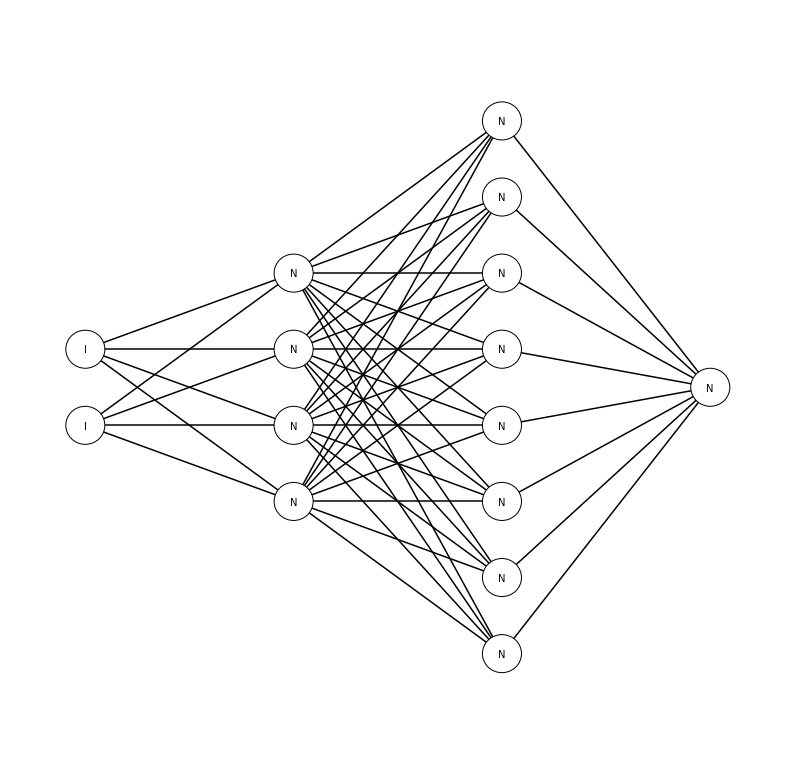

In [24]:
network = Network.builder() \
    .sigm_dense(neurons = 4, inputs = 2) \
    .sigm_dense(neurons = 8) \
    .sigm_dense(neurons = 1) \
    .build()

network.plot()

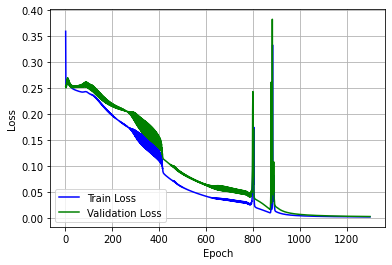

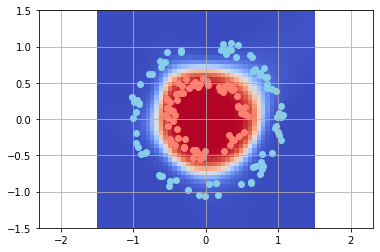

,Epoch,Train Loss,Validation Loss
0,1,0.359348,0.252719
1,2,0.251313,0.250151
2,3,0.252159,0.255902
3,4,0.253382,0.252426
4,5,0.255142,0.261073
...,...,...,...
1295,1296,0.001260,0.002019
1296,1297,0.001258,0.002014
1297,1298,0.001255,0.002010
1298,1299,0.001252,0.002006


In [25]:
X_train, X_val, Y_train, Y_val = dataset.train_test(0.3)

summary = network.train(
    train_set=(X_train, Y_train),
    validation_set=(X_val, Y_val),
    lr=0.05,
    epochs=1_300,
    loss_fn=MSEFunction(),
    callbacks=[
        TrainSummaryCallback(), 
        PlotLossesCallback(),
        PlotLerningCallback()
    ]
)

summary.show()